# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [229]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/diogomatoschaves/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diogomatoschaves/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/diogomatoschaves/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [158]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/diogomatoschaves/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
# import libraries
from functools import reduce
import pandas as pd
import numpy as np
import re
from sqlalchemy import create_engine

from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import pos_tag

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sb

In [3]:
# load data from database
engine = create_engine('sqlite:///../data/DisasterResponse.db')
df = pd.read_sql_table('messages', engine)
X = df['message']
y = df.iloc[:, 4:]

In [4]:
for i, column in enumerate(df.columns[4:]):
    print(np.bincount(np.array(y)[:, i]), column)

[ 6122 20093] related
[21741  4474] request
[26097   118] offer
[15355 10860] aid_related
[24131  2084] medical_help
[24902  1313] medical_products
[25491   724] search_and_rescue
[25744   471] security
[25355   860] military
[26215] child_alone
[24543  1672] water
[23292  2923] food
[23901  2314] shelter
[25810   405] clothing
[25611   604] money
[25917   298] missing_people
[25340   875] refugees
[25021  1194] death
[22769  3446] other_aid
[24510  1705] infrastructure_related
[25014  1201] transport
[24882  1333] buildings
[25683   532] electricity
[26056   159] tools
[25932   283] hospitals
[26095   120] shops
[25906   309] aid_centers
[25064  1151] other_infrastructure
[18918  7297] weather_related
[24060  2155] floods
[23772  2443] storm
[25933   282] fire
[23760  2455] earthquake
[25685   530] cold
[24839  1376] other_weather
[21140  5075] direct_report


### 2. Write a tokenization function to process your text data

In [5]:
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer(language='english')

In [6]:
def tokenize(text, include_numbers=True):
    
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    
    text = re.sub(url_pattern, 'urlplaceholder', text)
        
    pattern = r'[^a-zA-Z0-9]' if include_numbers else r'[^a-zA-Z]'
    
    text = re.sub(pattern, ' ', text)
        
    pattern = r'[0-9]+'
    
    text = re.sub(pattern, 'numberplaceholder', text)
        
    words = word_tokenize(text)
    
    words = [stemmer.stem(lemmatizer.lemmatize(word.lower().strip())) for word in words if word not in stop_words]
    
    return words

In [7]:
print(X[17])
tokenize("Please check 635, you'll find the information you need there")

are you going to call me or do you want me to call ou? let me know?


['pleas', 'check', 'numberplacehold', 'find', 'inform', 'need']

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [7]:
tokenize_with_numbers = lambda text: tokenize(text, True)
tokenize_without_numbers = lambda text: tokenize(text, False)

In [15]:
class DenseTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [8]:
class VerbCounter(BaseEstimator, TransformerMixin):
    
    def count_verbs(self, text):
        # tokenize by sentences
        sentence_list = sent_tokenize(text)
    
        total = 0
        for sentence in sentence_list:
            # tokenize each sentence into words and tag part of speech
            pos_tags = pos_tag(word_tokenize(sentence))

            total += reduce(lambda total, word: total + 1 if 'VB' in word[1] else total, pos_tags, 0)

        return total
    
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, y=None, **fit_params):
        vect_func = np.vectorize(self.count_verbs)
        return pd.DataFrame(vect_func(X))

In [184]:
count_verbs(X[11])

I am in Petionville.
[('I', 'PRP'), ('am', 'VBP'), ('in', 'IN'), ('Petionville', 'NNP'), ('.', '.')]
I need more information regarding 4636
[('I', 'PRP'), ('need', 'VBP'), ('more', 'JJR'), ('information', 'NN'), ('regarding', 'NN'), ('4636', 'CD')]


2

In [119]:
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=200)))
])

In [9]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('text_processing', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer()),
        ])),
        ('verb_counter_normalized', Pipeline([
            ('count_verbs', VerbCounter()),
            ('scaler', StandardScaler())
        ]))
    ])),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=200)))
])

In [249]:
len(pipeline.steps[0][1].transformer_list[0][1].steps[0][1].vocabulary_)

20806

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [11]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('text_processing',
                                                 Pipeline(memory=None,
                                                          steps=[('vect',
                                                                  CountVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.int64'>,
                                                                                  encoding='utf-8',
                                                                                  input='content',
                                                                                  l

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [12]:
y_pred = pipeline.predict(X_test)

In [78]:
columns = y.columns

precisions = []
recalls = []
fscores = []
accuracies = []
actual_positives = []

for i, column in enumerate(columns):
    
    y_test_col = np.array(y_test)[:, i]
    y_pred_col = np.array(y_pred)[:, i]
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test_col, y_pred_col, average='binary', zero_division=0)
    
    accuracy = accuracy_score(y_test_col, y_pred_col)
    
    actual_positive = np.bincount(y_test_col)
    
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    accuracies.append(accuracy)
    actual_positives.append(actual_positive[1] if len(actual_positive) >= 2 else 0)
    
results = pd.DataFrame({
    'category': columns, 
    'precision': precisions, 
    'recall': recalls, 
    'f_score': fscores, 
    'accuracy': accuracies,
    'actual_positives': actual_positives
})

*precision_recall_fscore, _ = precision_recall_fscore_support(
        y_test, y_pred, average="micro"
    )

accuracy = accuracy_score(np.array(y_test), np.array(y_pred))

results = results.append(
    pd.DataFrame([["total", *precision_recall_fscore, accuracy, 0]], columns=results.columns)
)

results.set_index("category", inplace=True)

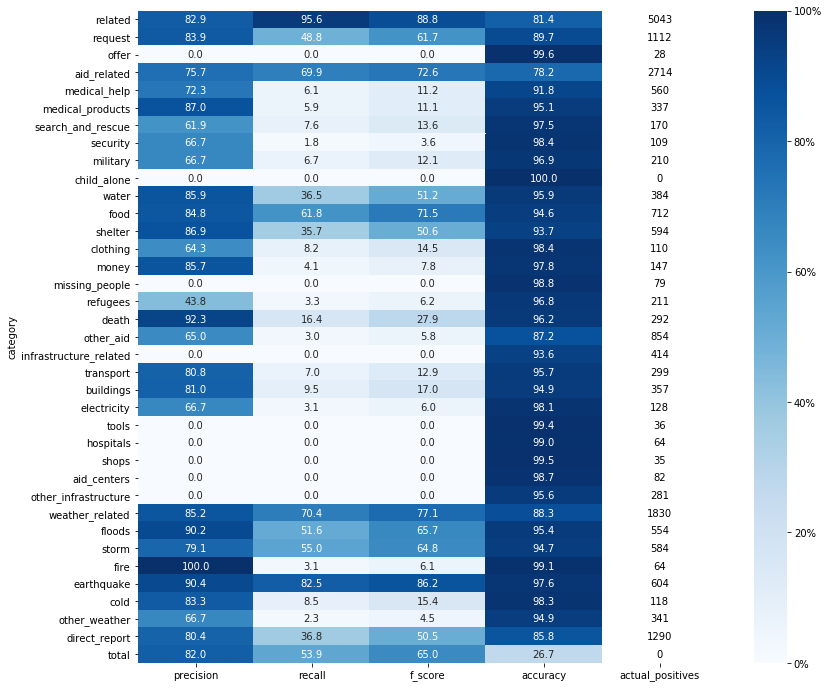

In [79]:
plt.figure(figsize=(13, 12))

mask = np.zeros(results.shape)
mask[:,-1] = True

ax = sb.heatmap(
    results*100,
    vmin=results.values[:,:-1].ravel().min() * 100,
    vmax=results.values[:,:-1].ravel().max() * 100,
    mask=mask, 
    annot=True, 
    fmt=".1f", 
    cmap='Blues', 
    cbar_kws={'format': '%.0f%%'}
);

for (j,i), label in np.ndenumerate(results.values):
    if i == 4:
        ax.text(i+0.5, j+0.5, int(label), 
                fontdict=dict(ha='center',  va='center',
                                         color='black', fontsize=10))

plt.savefig('../utils/img/random_forest_n_estimators=200')

In [233]:
y_pred = pipeline.predict(X_test)

In [234]:
columns = y.columns

precisions = []
recalls = []
fscores = []

for i, column in enumerate(columns):
    
    y_test_col = np.array(y_test)[:, i]
    y_pred_col = np.array(y_pred)[:, i]
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test_col, y_pred_col, average='binary')
    
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    
results = pd.DataFrame({'category': columns, 'precision': precisions, 'recall': recalls, 'f_score': fscores})

*precision_recall_fscore, _ = precision_recall_fscore_support(
        y_test, y_pred, average="micro"
    )

results = results.append(
    pd.DataFrame([["total", *precision_recall_fscore]], columns=results.columns)
)

results.set_index("category", inplace=True)

/Users/diogomatoschaves/.conda/envs/disaster-response-analysis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/diogomatoschaves/.conda/envs/disaster-response-analysis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


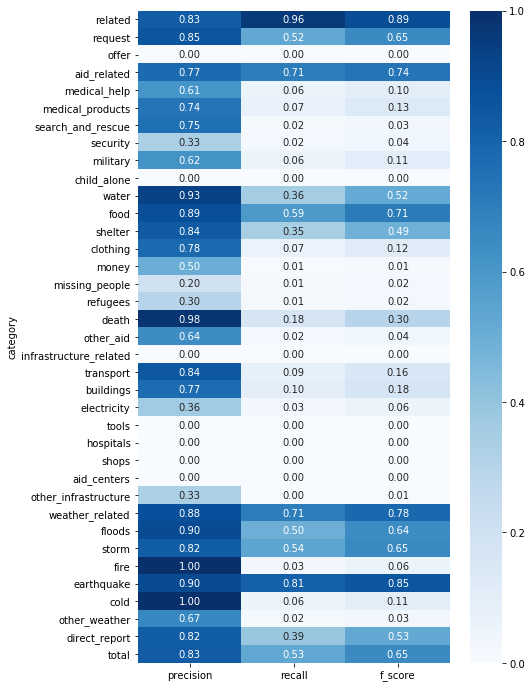

In [235]:
plt.figure(figsize=(7, 12))
sb.heatmap(results, annot=True, fmt=".2f", cmap='Blues');

In [39]:
f1_score(y_test, y_pred, average='micro')

0.4948357247445382

In [213]:
y_pred = pipeline.predict(X_test)

In [214]:
columns = y.columns

precisions = []
recalls = []
fscores = []

for i, column in enumerate(columns):
    
    y_test_col = np.array(y_test)[:, i]
    y_pred_col = np.array(y_pred)[:, i]
    
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test_col, y_pred_col, average='binary')
    
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)
    
results = pd.DataFrame({'category': columns, 'precision': precisions, 'recall': recalls, 'f_score': fscores})

*precision_recall_fscore, _ = precision_recall_fscore_support(
        y_test, y_pred, average="micro"
    )

results = results.append(
    pd.DataFrame([["total", *precision_recall_fscore]], columns=results.columns)
)

results.set_index("category", inplace=True)

/Users/diogomatoschaves/.conda/envs/disaster-response-analysis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/diogomatoschaves/.conda/envs/disaster-response-analysis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


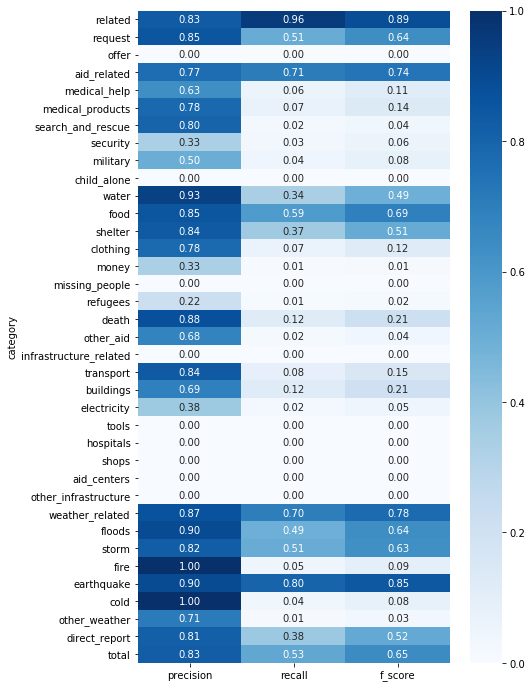

In [215]:
plt.figure(figsize=(7, 12))
sb.heatmap(results, annot=True, fmt=".2f", cmap='Blues');

In [181]:
def count_verbs(text):
    # tokenize by sentences
    sentence_list = sent_tokenize(text)
    
    total = 0
    for sentence in sentence_list:
        # tokenize each sentence into words and tag part of speech
        pos_tags = pos_tag(word_tokenize(sentence))
        
        print(sentence)
        print(pos_tags)
        
        total += reduce(lambda total, word: total + 1 if 'VB' in word[1] else total, pos_tags, 0)
        
    return total

In [210]:
for i, column in enumerate(df.columns[4:]):
    
    y_test_col = np.array(y_test)[:, i]
    y_pred_col = np.array(y_pred)[:, i]
    
    print(classification_report(y_test_col, y_pred_col, labels=np.unique(y_pred[:, i])))
    print(confusion_matrix(y_test_col, y_pred_col, labels=np.unique(y_pred[:, i])))
    print(accuracy_score(y_test_col, y_pred_col))
    print(balanced_accuracy_score(y_test_col, y_pred_col))
    print(precision_recall_fscore_support(y_test_col, y_pred_col, average='binary'))
    

              precision    recall  f1-score   support

           0       0.73      0.38      0.50      1543
           1       0.83      0.96      0.89      5011

    accuracy                           0.82      6554
   macro avg       0.78      0.67      0.69      6554
weighted avg       0.81      0.82      0.80      6554

[[ 587  956]
 [ 221 4790]]
0.820415013732072
0.668162382357
(0.8336233901844762, 0.9558970265416085, 0.890582876266617, None)
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      5453
           1       0.86      0.52      0.65      1101

    accuracy                           0.91      6554
   macro avg       0.88      0.75      0.80      6554
weighted avg       0.90      0.91      0.90      6554

[[5359   94]
 [ 527  574]]
0.9052487030820873
0.7520530075104689
(0.8592814371257484, 0.5213442325158947, 0.6489542114188807, None)
              precision    recall  f1-score   support

           0       1.00      1.00

### 6. Improve your model
Use grid search to find better parameters. 

In [200]:
tokenize_with_numbers = lambda text: tokenize(text, True)
tokenize_without_numbers = lambda text: tokenize(text, False)

In [221]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [109]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
#     ('dense', DenseTransformer()),
    ('clf', MultiOutputClassifier(KNeighborsClassifier(), n_jobs=-1))
])

In [110]:
parameters = {
#     'vect__tokenizer': [tokenize_with_numbers, tokenize_without_numbers],
#     'tfidf__smooth_idf': [True, False],
    'clf__estimator__n_neighbors': [1, 5, 10, 50]
#     'clf__estimator__n_estimators': [10, 30, 60, 100, 150, 200],
#     'clf__estimator__bootstrap': [True, False]
}

cv = GridSearchCV(pipeline, param_grid=parameters)

In [111]:
cv.param_grid

{'clf__estimator__n_neighbors': [1, 5, 10, 50]}

In [118]:
cv.param_grid

{'clf__estimator__n_neighbors': [1, 5, 10, 50]}

In [117]:
list(filter(lambda x: x[0] == 'clf', cv.estimator.steps))[0][1].estimator

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [224]:
cv.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        p

### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [227]:
cv.best_params_

{'clf__estimator__n_neighbors': 10}

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.